In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [72]:
import os
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from torch.utils.data import DataLoader, random_split
import torch.optim as optim


In [75]:
import os
from PIL import Image
import pandas as pd
import torch
from torch.utils.data import Dataset
import torchvision.transforms.functional as TF
import random

class FloodDataset(Dataset):
    def __init__(self, csv_file, img_dir, mask_dir, img_transform=None, mask_transform=None, augment=False):
        self.data = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.img_transform = img_transform
        self.mask_transform = mask_transform
        self.augment = augment

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.data.iloc[idx, 0])
        mask_name = os.path.join(self.mask_dir, self.data.iloc[idx, 1])
        
        image = Image.open(img_name).convert("RGB")
        mask = Image.open(mask_name).convert("L")  # Convert mask to grayscale
        
        if self.augment:
            image, mask = self.apply_augmentation(image, mask)
        
        if self.img_transform:
            image = self.img_transform(image)
        
        if self.mask_transform:
            mask = self.mask_transform(mask)
        else:
            mask = TF.to_tensor(mask)
        
        # Ensure mask is binary
        mask = (mask > 0.5).float()
        
        return image, mask

    def apply_augmentation(self, image, mask):
        # Random horizontal flipping
        if random.random() > 0.5:
            image = TF.hflip(image)
            mask = TF.hflip(mask)
        
        # Random vertical flipping
        if random.random() > 0.5:
            image = TF.vflip(image)
            mask = TF.vflip(mask)
        
        # Random rotation
        if random.random() > 0.5:
            angle = random.randint(-30, 30)
            image = TF.rotate(image, angle)
            mask = TF.rotate(mask, angle)
        
        return image, mask

In [76]:
img_path = '/kaggle/input/cosmo-segmentation/Segmentation dataset -20241018T225923Z-001/Segmentation dataset/Segmentation dataset/Image'
mask_path = '/kaggle/input/cosmo-segmentation/Segmentation dataset -20241018T225923Z-001/Segmentation dataset/Segmentation dataset/Mask' 
csv_path = '/kaggle/input/cosmo-segmentation/Segmentation dataset -20241018T225923Z-001/Segmentation dataset/Segmentation dataset/metadata.csv'

In [78]:
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset
from torchvision import transforms

# Assuming we're using the FloodDataset class we defined earlier

# Image transforms
img_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Mask transforms
mask_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

# Create the full dataset
full_dataset = FloodDataset(
    csv_file=csv_path, 
    img_dir=img_path, 
    mask_dir=mask_path, 
    img_transform=img_transform,
    mask_transform=mask_transform,
    augment=True  # We'll apply augmentation only to the training set later
)

In [79]:
# Set the ratio for the validation set (e.g., 20% of the data)
val_ratio = 0.2

# Get the total number of samples
num_samples = len(full_dataset)

# Generate indices for the split
indices = list(range(num_samples))

# Perform the split
train_indices, val_indices = train_test_split(
    indices, 
    test_size=val_ratio, 
    random_state=42  # Set a random state for reproducibility
)

# Create Subset objects for training and validation
train_dataset = Subset(full_dataset, train_indices)
val_dataset = Subset(full_dataset, val_indices)

In [80]:
class AugmentedSubset(Subset):
    def __init__(self, dataset, indices, augment=False):
        super().__init__(dataset, indices)
        self.augment = augment

    def __getitem__(self, idx):
        image, mask = super().__getitem__(idx)
        if self.augment:
            # Apply augmentation
            image, mask = self.dataset.apply_augmentation(image, mask)
        return image, mask

# Recreate our datasets with appropriate augmentation settings
train_dataset = AugmentedSubset(full_dataset, train_indices, augment=True)
val_dataset = AugmentedSubset(full_dataset, val_indices, augment=False)

In [81]:
from torch.utils.data import DataLoader

batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

In [82]:
import torch
import torch.nn as nn

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, features=[64, 128, 256, 512]):
        super(UNet, self).__init__()
        self.downs = nn.ModuleList()
        self.ups = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part of U-Net
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up part of U-Net
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(feature*2, feature, kernel_size=2, stride=2)
            )
            self.ups.append(DoubleConv(feature*2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = torch.nn.functional.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)

In [83]:
import torch
import torch.nn as nn
import torch.optim as optim

# Assuming we've already defined our UNet class

# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Create the model and move it to the device
model = UNet(in_channels=3, out_channels=1).to(device)

Using device: cuda


In [84]:
criterion = nn.BCEWithLogitsLoss()
learning_rate = 1e-4
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [90]:
import torch

def iou_score(outputs, targets, smooth=1e-6):
    outputs = (outputs > 0.5).float()  # binarize the outputs
    targets = (targets > 0.5).float()  # ensure targets are binary
    
    intersection = (outputs * targets).sum((1, 2))
    union = outputs.sum((1, 2)) + targets.sum((1, 2)) - intersection
    
    iou = (intersection + smooth) / (union + smooth)
    return iou.mean()

def dice_coefficient(outputs, targets, smooth=1e-6):
    outputs = (outputs > 0.5).float()  # binarize the outputs
    targets = (targets > 0.5).float()  # ensure targets are binary
    
    intersection = (outputs * targets).sum((1, 2))
    union = outputs.sum((1, 2)) + targets.sum((1, 2))
    
    dice = (2. * intersection + smooth) / (union + smooth)
    return dice.mean()

In [91]:
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for images, masks in loader:
        images = images.to(device)
        masks = masks.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    return total_loss / len(loader)

def validate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    total_iou = 0
    total_dice = 0
    num_batches = len(loader)
    
    with torch.no_grad():
        for images, masks in loader:
            images = images.to(device)
            masks = masks.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, masks)
            
            # Apply sigmoid to get probabilities
            outputs = torch.sigmoid(outputs)
            
            # Ensure outputs and masks have the same shape
            outputs = outputs.squeeze(1)  # Remove channel dim if it exists
            masks = masks.squeeze(1)  # Remove channel dim if it exists
            
            # Compute IoU and Dice
            batch_iou = iou_score(outputs, masks)
            batch_dice = dice_coefficient(outputs, masks)
            
            total_loss += loss.item()
            total_iou += batch_iou.item()
            total_dice += batch_dice.item()
    
    avg_loss = total_loss / num_batches
    avg_iou = total_iou / num_batches
    avg_dice = total_dice / num_batches
    
    return avg_loss, avg_iou, avg_dice

In [100]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

In [97]:
len(train_dataset)

232

In [104]:
num_epochs = 25  # You've already trained for 25 epochs
best_val_loss = 0.2327  # Your best validation loss from previous training

for epoch in range(num_epochs):
    train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_iou, val_dice = validate(model, val_loader, criterion, device)
    
    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Train Loss: {train_loss:.4f}, "
          f"Val Loss: {val_loss:.4f}, "
          f"Val IoU: {val_iou:.4f}, "
          f"Val Dice: {val_dice:.4f}")
    
    # Learning rate scheduling
    scheduler.step(val_loss)
    
    # Save the best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pth')
        print(f"Saved new best model with validation loss: {best_val_loss:.4f}")

Epoch 1/25, Train Loss: 0.1859, Val Loss: 0.2386, Val IoU: 0.7781, Val Dice: 0.8661
Epoch 2/25, Train Loss: 0.1878, Val Loss: 0.2468, Val IoU: 0.7740, Val Dice: 0.8645
Epoch 3/25, Train Loss: 0.1891, Val Loss: 0.2451, Val IoU: 0.7763, Val Dice: 0.8656
Epoch 4/25, Train Loss: 0.1849, Val Loss: 0.2379, Val IoU: 0.7773, Val Dice: 0.8664
Epoch 5/25, Train Loss: 0.1856, Val Loss: 0.2387, Val IoU: 0.7777, Val Dice: 0.8662
Epoch 6/25, Train Loss: 0.1854, Val Loss: 0.2442, Val IoU: 0.7789, Val Dice: 0.8675
Epoch 7/25, Train Loss: 0.1832, Val Loss: 0.2457, Val IoU: 0.7775, Val Dice: 0.8668
Epoch 8/25, Train Loss: 0.1867, Val Loss: 0.2355, Val IoU: 0.7772, Val Dice: 0.8656
Epoch 9/25, Train Loss: 0.1832, Val Loss: 0.2324, Val IoU: 0.7851, Val Dice: 0.8729
Saved new best model with validation loss: 0.2324
Epoch 10/25, Train Loss: 0.1843, Val Loss: 0.2367, Val IoU: 0.7800, Val Dice: 0.8679
Epoch 11/25, Train Loss: 0.1854, Val Loss: 0.2425, Val IoU: 0.7783, Val Dice: 0.8673
Epoch 12/25, Train Loss:

In [105]:
current_lr = optimizer.param_groups[0]['lr']

In [107]:
model_path = '/kaggle/working/entire_model.pth'
torch.save(model, model_path)

In [121]:
# Get a batch of data
dataiter = iter(dataloader)
images, masks = next(dataiter)

# Visualize the first image and mask in the batch with unnormalization
# visualize_sample(images[1], masks[1], mean, std)
images[1].type()

'torch.FloatTensor'

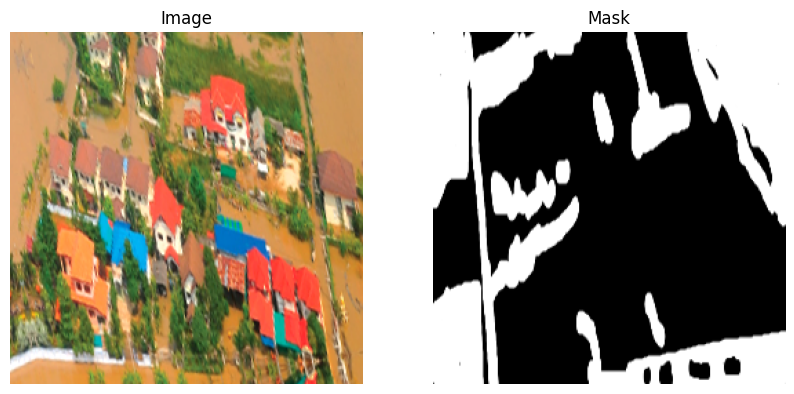

In [120]:
# import matplotlib.pyplot as plt
# import torchvision.transforms.functional as TF

# # Define an unnormalization function to reverse the normalization
# def unnormalize(tensor, mean, std):
#     """Reverses normalization for display purposes."""
#     for t, m, s in zip(tensor, mean, std):
#         t.mul_(s).add_(m)  # Unnormalize the image (inplace)
#     return tensor

# def visualize_sample(image, mask, mean, std):
#     # Unnormalize the image before visualizing
#     image = unnormalize(image.clone(), mean, std)  # Clone so as not to modify the original tensor
#     image = TF.to_pil_image(image)  # Convert tensor to PIL image
#     mask = TF.to_pil_image(mask)    # Convert tensor to PIL grayscale image
    
#     # Plot side by side
#     fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    
#     ax[0].imshow(image)
#     ax[0].set_title("Image")
#     ax[0].axis("off")
    
#     ax[1].imshow(mask, cmap="gray")
#     ax[1].set_title("Mask")
#     ax[1].axis("off")
    
#     plt.show()


# from torch.utils.data import DataLoader

# # Mean and std used during normalization
# mean = [0.485, 0.456, 0.406]
# std = [0.229, 0.224, 0.225]

# # Create DataLoader (assuming dataset is already defined)
# dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

# # Get a batch of data
# dataiter = iter(dataloader)
# images, masks = next(dataiter)

# # Visualize the first image and mask in the batch with unnormalization
# visualize_sample(images[1], masks[1], mean, std)


In [123]:
dataset = pd.read_csv(csv_path)

In [125]:
from torch.utils.data import DataLoader

# Assuming that 'csv_file', 'img_dir', 'mask_dir' are defined
dataset = FloodDataset(
    csv_file=csv_path, 
    img_dir=img_path, 
    mask_dir=mask_path, 
    img_transform=None,  # Add any transforms if necessary
    mask_transform=None,  # Add any transforms if necessary
    augment=False  # Set True if augmentation is needed
)

# Create DataLoader
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)


In [ ]:
import matplotlib.pyplot as plt
import torch.nn.functional as F

def visualize_from_dataloader(model, dataloader, device="cpu"):
    # Set the model to evaluation mode
    model.eval()

    # Get a batch of images and masks from the DataLoader
    for image, actual_mask in dataloader:
        # Move to the device (GPU/CPU)
        image = image.to(device)
        actual_mask = actual_mask.to(device)
        
        # Get the predicted mask
        with torch.no_grad():
            predicted_mask = model(image)

        # Squeeze to remove batch and channel dimensions
        predicted_mask = predicted_mask.squeeze(0).squeeze(0).cpu()
        predicted_mask = (predicted_mask > 0.5).float()  # Binarize prediction

        # Move image and actual mask back to CPU for visualization
        image = image.squeeze(0).permute(1, 2, 0).cpu()  # Convert to HWC for visualization
        actual_mask = actual_mask.squeeze(0).cpu()

        # Plot the original image, actual mask, and predicted mask
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))

        axes[0].imshow(image)
        axes[0].set_title("Original Image")
        axes[0].axis("off")

        axes[1].imshow(actual_mask, cmap='gray')
        axes[1].set_title("Actual Mask")
        axes[1].axis("off")

        axes[2].imshow(predicted_mask, cmap='gray')
        axes[2].set_title("Predicted Mask")
        axes[2].axis("off")

        plt.tight_layout()
        plt.show()

        # Break after showing the first batch for visualization
        break

# Example usage
# Assuming 'model' is an instance of UNet
visualize_from_dataloader(model, dataloader, device=torch.device("cuda" if torch.cuda.is_available() else "cpu"))


In [ ]:
import os
import torch
import torchvision.transforms.functional as TF
from PIL import Image
import matplotlib.pyplot as plt

def infer_and_save(model, dataset, device, output_dir, threshold=0.5):
    """
    Perform inference using the trained model, save the original images and predicted masks.
    
    Parameters:
    - model: Trained model to use for inference.
    - dataset: Dataset object (FloodDataset) containing image paths.
    - device: Device (CPU or GPU) on which the model runs.
    - output_dir: Directory where the results will be saved.
    - threshold: Threshold to binarize the output masks (default=0.5).
    """
    model.eval()  # Set model to evaluation mode

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    with torch.no_grad():
        for idx in range(len(dataset)):
            image, _ = dataset[idx]
            image = torch.Tensor(np.array(image)).unsqueeze(0).to(device)  # Add batch dimension

            # Perform inference
            output = model(image)
            output = torch.sigmoid(output)  # Apply sigmoid to get probabilities
            output = output.squeeze(1)  # Remove channel dim

            # Binarize the output mask
            output_mask = (output > threshold).float()

            # Convert tensors to images
            image_np = TF.to_pil_image(image.squeeze(0).cpu())  # Convert input image
            output_mask_np = TF.to_pil_image(output_mask.squeeze(0).cpu())  # Convert mask

            # Save the original image and the mask
            image_filename = f"image_{idx}.png"
            mask_filename = f"mask_{idx}.png"

            image_np.save(os.path.join(output_dir, image_filename))
            output_mask_np.save(os.path.join(output_dir, mask_filename))

            # Optionally: Display the original image and predicted mask side by side
            plt.figure(figsize=(10, 5))
            plt.subplot(1, 2, 1)
            plt.imshow(image_np)
            plt.title('Original Image')

            plt.subplot(1, 2, 2)
            plt.imshow(output_mask_np, cmap='gray')
            plt.title('Predicted Mask')

            plt.show()

# Example usage
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet()  # Assuming the model is already defined
model_path = '/kaggle/working/best_model.pth'
model.load_state_dict(torch.load(model_path))  # Load your trained model
model = model.to(device)

dataset = FloodDataset(csv_path, img_path, mask_path) # Your test dataset
output_dir = "inference_results"

infer_and_save(model, dataset, device, output_dir)

In [106]:
current_lr

1.0000000000000004e-08

In [135]:
import torch
from PIL import Image
import torchvision.transforms as transforms

def predict_mask(model, image_path, device):
    model.eval()
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0).to(device)
    
    with torch.no_grad():
        output = model(image)
        predicted_mask = torch.sigmoid(output) > 0.5
    
    return predicted_mask.squeeze().cpu().numpy()

model = UNet(in_channels=3, out_channels=1).to(device)
model.load_state_dict(torch.load('best_model.pth'))
image_path = '/kaggle/input/cosmo-segmentation/Segmentation dataset -20241018T225923Z-001/Segmentation dataset/Segmentation dataset/Image/0.jpg'
predicted_mask = predict_mask(model, image_path, device)

/tmp/ipykernel_30/20713775.py:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


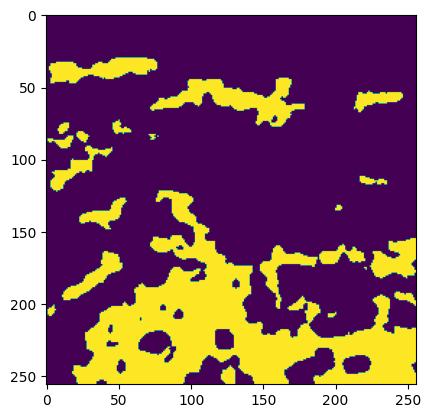

In [143]:
plt.imshow(predicted_mask)

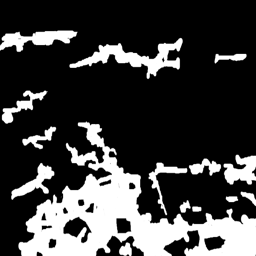

In [141]:
Image.open("/kaggle/input/cosmo-segmentation/Segmentation dataset -20241018T225923Z-001/Segmentation dataset/Segmentation dataset/Mask/0.png").resize((256,256))

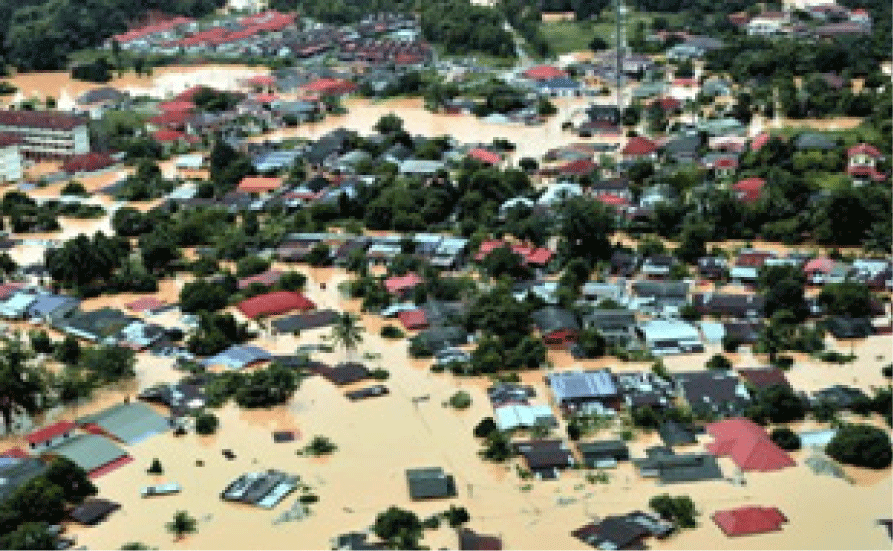

In [138]:
Image.open("/kaggle/input/cosmo-segmentation/Segmentation dataset -20241018T225923Z-001/Segmentation dataset/Segmentation dataset/Image/0.jpg")

In [ ]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

def compare_masks(predicted_mask, true_mask_path):
    true_mask = np.array(Image.open(true_mask_path).convert("L")) > 128
    
    iou = np.logical_and(predicted_mask, true_mask).sum() / np.logical_or(predicted_mask, true_mask).sum()
    dice = 2 * np.logical_and(predicted_mask, true_mask).sum() / (predicted_mask.sum() + true_mask.sum())
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
    ax1.imshow(predicted_mask, cmap='gray')
    ax1.set_title('Predicted Mask')
    ax2.imshow(true_mask, cmap='gray')
    ax2.set_title('True Mask')
    ax3.imshow((predicted_mask.astype(int) + true_mask.astype(int)), cmap='RdYlGn')
    ax3.set_title('Overlay (Green: True Positive, Red: False, Yellow: True Negative)')
    plt.show()
    
    print(f"IoU: {iou:.4f}")
    print(f"Dice Coefficient: {dice:.4f}")

true_mask_path = '/kaggle/input/cosmo-segmentation/Segmentation dataset -20241018T225923Z-001/Segmentation dataset/Segmentation dataset/Mask/0.png'
compare_masks(predicted_mask, true_mask_path)

In [ ]:
# Epoch 23/25, Train Loss: 0.2166, Val Loss: 0.2577, Val IoU: 0.7511, Val Dice: 0.8475
# Epoch 24/25, Train Loss: 0.2080, Val Loss: 0.2499, Val IoU: 0.7688, Val Dice: 0.8613
# Epoch 25/25, Train Loss: 0.2154, Val Loss: 0.2445, Val IoU: 0.7697, Val Dice: 0.8627
# Saved new best model with validation loss: 0.2445

In [63]:
# # Split dataset into training and validation sets (80% train, 20% validation)
# train_size = int(0.8 * len(dataset))
# val_size = len(dataset) - train_size
# train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# # Create DataLoaders
# train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

In [64]:
# dataiter = iter(train_loader)
# images, masks = next(dataiter)

# # Visualize the first image and mask in the batch with unnormalization
# # visualize_sample(images[1], masks[1], mean, std)
# images[1].type()

In [65]:
# import matplotlib.pyplot as plt
# import torchvision.transforms.functional as TF

# # Define an unnormalization function to reverse the normalization
# def unnormalize(tensor, mean, std):
#     """Reverses normalization for display purposes."""
#     for t, m, s in zip(tensor, mean, std):
#         t.mul_(s).add_(m)  # Unnormalize the image (inplace)
#     return tensor

# def visualize_sample(image, mask, mean, std):
#     # Unnormalize the image before visualizing
#     image = unnormalize(image.clone(), mean, std)  # Clone so as not to modify the original tensor
#     image = TF.to_pil_image(image)  # Convert tensor to PIL image
#     mask = TF.to_pil_image(mask)    # Convert tensor to PIL grayscale image
    
#     # Plot side by side
#     fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    
#     ax[0].imshow(image)
#     ax[0].set_title("Image")
#     ax[0].axis("off")
    
#     ax[1].imshow(mask, cmap="gray")
#     ax[1].set_title("Mask")
#     ax[1].axis("off")
    
#     plt.show()


# from torch.utils.data import DataLoader

# # Mean and std used during normalization
# mean = [0.485, 0.456, 0.406]
# std = [0.229, 0.224, 0.225]

# # Create DataLoader (assuming dataset is already defined)
# dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

# # Get a batch of data
# dataiter = iter(dataloader)
# images, masks = next(dataiter)

# # Visualize the first image and mask in the batch with unnormalization
# visualize_sample(images[1], masks[1], mean, std)


In [66]:
# import torch
# import torch.nn as nn

# class UNet(nn.Module):
#     def __init__(self):
#         super(UNet, self).__init__()
#         # Encoder (downsampling)
#         self.enc1 = self.conv_block(3, 64)
#         self.enc2 = self.conv_block(64, 128)
#         self.enc3 = self.conv_block(128, 256)
#         self.enc4 = self.conv_block(256, 512)
#         self.enc5 = self.conv_block(512, 1024)
        
#         # Decoder (upsampling)
#         self.upconv5 = self.upconv_block(1024, 512)
#         self.dec5 = self.conv_block(1024, 512, pool=False)
#         self.upconv4 = self.upconv_block(512, 256)
#         self.dec4 = self.conv_block(512, 256, pool=False)
#         self.upconv3 = self.upconv_block(256, 128)
#         self.dec3 = self.conv_block(256, 128, pool=False)
#         self.upconv2 = self.upconv_block(128, 64)
#         self.dec2 = self.conv_block(128, 64, pool=False)
#         self.upconv1 = self.upconv_block(64, 32)
#         self.dec1 = self.conv_block(35, 64, pool=False)
        
#         self.final = nn.Conv2d(64, 1, kernel_size=1)

#     def conv_block(self, in_channels, out_channels, pool=True):
#         layers = [
#             nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True)
#         ]
#         if pool:
#             layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
#         return nn.Sequential(*layers)

#     def upconv_block(self, in_channels, out_channels):
#         return nn.Sequential(
#             nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
#             nn.ReLU(inplace=True)
#         )

#     def forward(self, x):
#         # Encoding
#         e1 = self.enc1(x)
#         e2 = self.enc2(e1)
#         e3 = self.enc3(e2)
#         e4 = self.enc4(e3)
#         e5 = self.enc5(e4)
        
#         # Decoding
#         d5 = self.upconv5(e5)
#         d5 = torch.cat([d5, e4], dim=1)
#         d5 = self.dec5(d5)
        
#         d4 = self.upconv4(d5)
#         d4 = torch.cat([d4, e3], dim=1)
#         d4 = self.dec4(d4)
        
#         d3 = self.upconv3(d4)
#         d3 = torch.cat([d3, e2], dim=1)
#         d3 = self.dec3(d3)
        
#         d2 = self.upconv2(d3)
#         d2 = torch.cat([d2, e1], dim=1)
#         d2 = self.dec2(d2)
        
#         d1 = self.upconv1(d2)
#         d1 = torch.cat([d1, x], dim=1)
#         d1 = self.dec1(d1)
        
#         out = self.final(d1)
#         return out

In [28]:
# model = UNet()
# input_tensor = torch.randn(16, 3, 256, 256)
# output = model(input_tensor)
# print("Final output shape:", output.shape)

In [67]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # Use GPU if available

# # Initialize the model (UNet in this case)
# model = UNet()
# model = model.to(device)  # Send the model to the GPU if available


In [68]:
# # Loss function (binary cross-entropy)
# criterion = nn.BCEWithLogitsLoss()

# # Optimizer
# optimizer = optim.Adam(model.parameters(), lr=0.001)

# # IoU metric function
# def iou_score(output, target):
#     smooth = 1e-6
#     output = torch.sigmoid(output)  # Convert logits to probabilities
#     output = (output > 0.5).float()  # Threshold
#     intersection = (output * target).sum()
#     union = output.sum() + target.sum() - intersection
#     return (intersection + smooth) / (union + smooth)

In [71]:
# num_epochs = 40  # Set the number of epochs
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # Use GPU if available

# for epoch in range(num_epochs):
#     model.train()  # Set model to training mode
#     train_loss = 0
#     train_iou = 0

#     # Training loop
#     for images, masks in train_loader:
#         images, masks = images.to(device), masks.to(device)

#         masks = masks.float()
#         # Zero the gradients
#         optimizer.zero_grad()
        
#         # Forward pass
#         outputs = model(images)
#         loss = criterion(outputs, masks)
        
#         # Backward pass
#         loss.backward()
#         optimizer.step()
        
#         train_loss += loss.item()
#         train_iou += iou_score(outputs, masks).item()

#     # Average training loss and IoU over all batches
#     train_loss /= len(train_loader)
#     train_iou /= len(train_loader)
    
#     print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss}, Train IoU: {train_iou}')
    
#     # Validation loop
#     model.eval()  # Set model to evaluation mode
#     val_loss = 0
#     val_iou = 0
#     with torch.no_grad():  # No gradient calculation needed during validation
#         for images, masks in val_loader:
#             images, masks = images.to(device), masks.to(device)
#             masks = masks.float()
#             outputs = model(images)
#             loss = criterion(outputs, masks)
#             val_loss += loss.item()
#             val_iou += iou_score(outputs, masks).item()

#     # Average validation loss and IoU over all batches
#     val_loss /= len(val_loader)
#     val_iou /= len(val_loader)
    
#     print(f'Epoch {epoch+1}/{num_epochs}, Val Loss: {val_loss}, Val IoU: {val_iou}')


Epoch 1/40, Train Loss: -1.8434028711925926e+23, Train IoU: 100.96084340413411
Epoch 1/40, Val Loss: -7.615329724272793e+23, Val IoU: 116.52462768554688
Epoch 2/40, Train Loss: -1.2076013001555804e+24, Train IoU: 99.70483601888021


KeyboardInterrupt: 